In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Read the CSV file into a DataFrame
df = pd.read_csv('assignment-4-option-1-training.csv')

# EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133731 entries, 0 to 133730
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      133731 non-null  object 
 1   Prod    133731 non-null  object 
 2   Quant   129252 non-null  float64
 3   Val     133215 non-null  float64
 4   Insp    133731 non-null  object 
dtypes: float64(2), object(3)
memory usage: 5.1+ MB


In [ ]:
df.describe()

,Quant,Val
count,1.292520e+05,1.332150e+05
mean,6.644151e+03,1.257081e+04
std,9.891108e+04,5.556184e+04
min,1.000000e+02,1.005000e+03
25%,1.090000e+02,1.420000e+03
50%,1.850000e+02,2.885000e+03
75%,8.870000e+02,8.730000e+03
max,1.101171e+07,3.913920e+06


<Axes: >

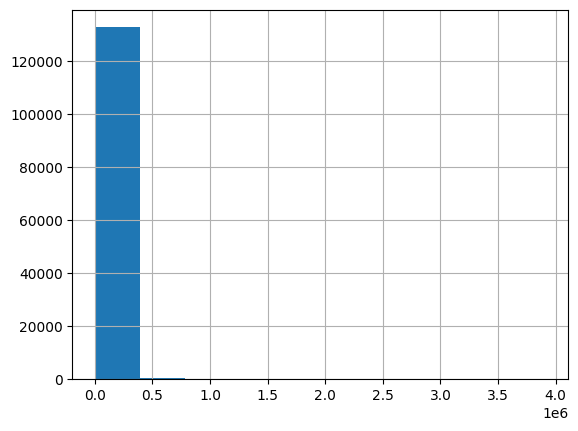

In [ ]:
df['Val'].hist()

<Axes: >

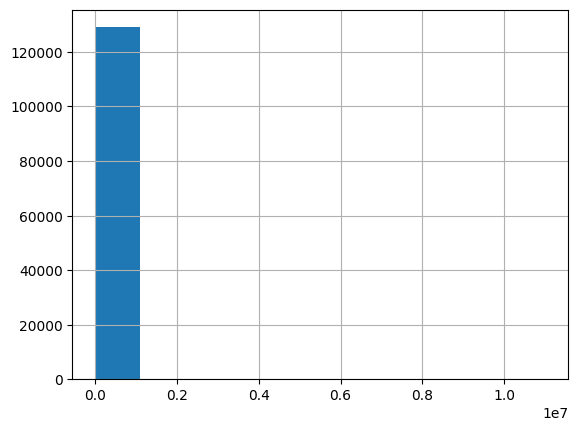

In [ ]:
df['Quant'].hist()

In [ ]:
# Check null for null values
df.isnull().sum()

ID          0
Prod        0
Quant    4479
Val       516
Insp        0
dtype: int64

# Data cleaning and preparation

In [ ]:
# Drop rows with null values
# df.dropna(inplace=True)

# Convert null values to 0 in the DataFrame
df.fillna(0, inplace=True)

In [ ]:
# Convert Prod to numerical using one-hot encoding
df = pd.get_dummies(df, columns=['Prod'])

In [ ]:
# Drop the ID and Insp columns from the test data
df_train = df.drop(['ID', 'Insp'], axis=1)

In [ ]:
df_train.head()

,Quant,Val,Prod_p1000,Prod_p1001,Prod_p1002,Prod_p1007,Prod_p1014,Prod_p1019,Prod_p1027,Prod_p1040,...,Prod_p983,Prod_p985,Prod_p989,Prod_p99,Prod_p991,Prod_p993,Prod_p994,Prod_p996,Prod_p997,Prod_p998
0,1032.0,4115.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,718.0,4780.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,585.0,3810.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,904.0,7310.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6989.0,35850.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Isolation Forest

In [ ]:
# calculate expected amount of anomalies/fraud transactions from test data
contamination = 1270/15732

# Train the isolation forest model
model = IsolationForest(contamination=contamination, random_state=42)
model.fit(df_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.08072718026951436, random_state=42)

## Evaluation on test data


In [ ]:
# load test data
test_data = pd.read_csv('assignment-4-option-1-test.csv')

In [ ]:
X_test = test_data
test_target = test_data['Insp']

In [ ]:
# Convert the categorical labels in test_target to numerical values
label_encoder = LabelEncoder()
encoded_test_target = label_encoder.fit_transform(test_target)

# convert to match prediction values 1 is "fraud" and 0 is "ok"
encoded_test_target = np.where(encoded_test_target == 0, 1, 0)

In [ ]:
# Get the unique values and their counts
unique_values, counts = np.unique(test_target, return_counts=True)

# Print the results
for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

fraud: 1270
ok: 14462


In [ ]:
# Get the unique values and their counts
unique_values, counts = np.unique(encoded_test_target, return_counts=True)

# Print the results
for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

0: 14462
1: 1270


In [ ]:
# Convert Prod to numerical using one-hot encoding
X_test = pd.get_dummies(X_test, columns=['Prod'])

In [ ]:
# Drop the ID and Insp columns from the test data
X_test.drop(['ID', 'Insp'], axis=1, inplace=True)

In [ ]:
# Convert null values to 0 in the DataFrame
X_test.fillna(0, inplace=True)

In [ ]:
# Predict the anomaly scores for the test data
predictions = model.predict(X_test)

#Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
predictions[predictions == 1] = 0
predictions[predictions == -1] = 1

In [ ]:
np.unique(predictions, return_counts=True)

(array([0, 1]), array([14221,  1511]))

In [ ]:
fraud_predictions = np.sum(predictions == 1)
print("Number of fraud predictions:", fraud_predictions)

Number of fraud predictions: 1511


In [ ]:
n_errors = (predictions != encoded_test_target).sum()

print(n_errors)

2629


In [ ]:
# Compare the predicted labels with the true labels and evaluate the model's performance
accuracy = accuracy_score(encoded_test_target, predictions)
precision = precision_score(encoded_test_target, predictions)
recall = recall_score(encoded_test_target, predictions)
f1 = f1_score(encoded_test_target, predictions)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Accuracy: 0.8328883803712179
Precision: 0.05029781601588352
Recall: 0.05984251968503937
F1-Score: 0.05465659834591873


### Confusion Matrix

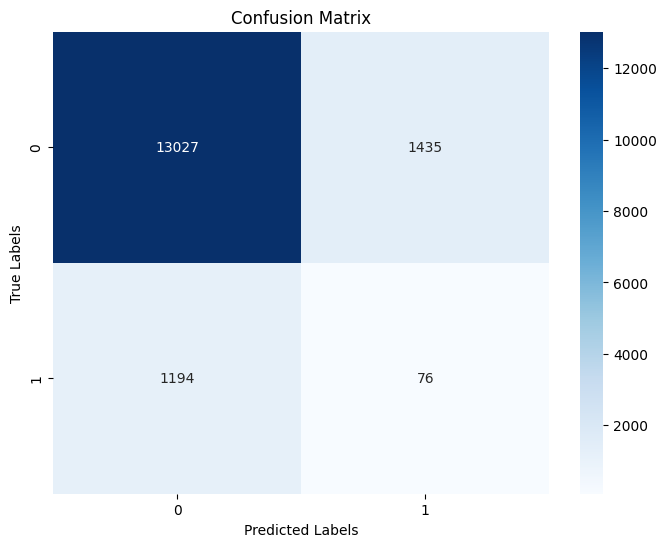

In [ ]:
# Create the confusion matrix
cm = confusion_matrix(encoded_test_target, predictions)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### Precision-Recall Curve

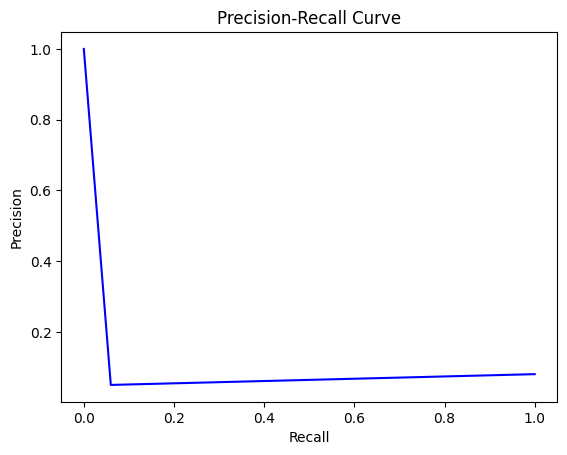

In [ ]:
# Compute precision and recall
precision, recall, thresholds = precision_recall_curve(encoded_test_target, predictions)

# Plot the precision-recall curve
plt.plot(recall, precision, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

### ROC Curve

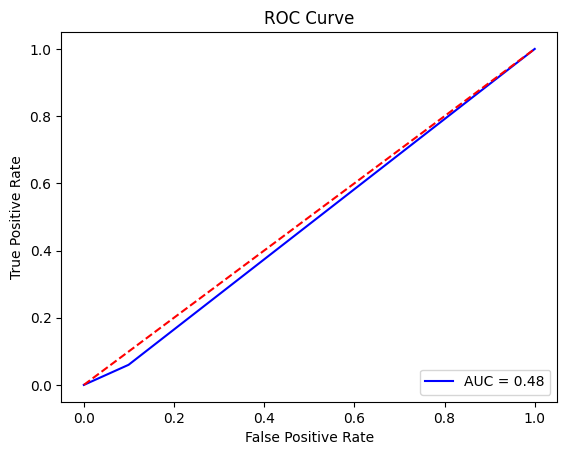

In [ ]:
# Compute false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(encoded_test_target, predictions)
roc_auc = roc_auc_score(encoded_test_target, predictions)

# Plot the ROC curve
plt.plot(fpr, tpr, color='b', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='r', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

#  DBSCAN/LOF

##Training Data


In [ ]:
#Import the libraries
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
stscaler = StandardScaler().fit(df_train)
X = stscaler.transform(df_train)

In [ ]:
X

array([[-0.05542167, -0.15159268, -0.0775768 , ..., -0.02869188,
        -0.01497936, -0.04022183],
       [-0.05865054, -0.13960201, -0.0775768 , ..., -0.02869188,
        -0.01497936, -0.04022183],
       [-0.06001818, -0.15709216, -0.0775768 , ..., -0.02869188,
        -0.01497936, -0.04022183],
       ...,
       [-0.06603376, -0.20739885, -0.0775768 , ..., -0.02869188,
        -0.01497936, -0.04022183],
       [-0.06497461, -0.20198953, -0.0775768 , ..., -0.02869188,
        -0.01497936, -0.04022183],
       [-0.06392574, -0.19667036, -0.0775768 , ..., -0.02869188,
        -0.01497936, -0.04022183]])

In [ ]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

In [ ]:
indices

array([[     0,  67904],
       [     1,  88369],
       [     2,  22681],
       ...,
       [133728,  88315],
       [133729, 114185],
       [133730,  88319]])

<function matplotlib.pyplot.show(close=None, block=None)>

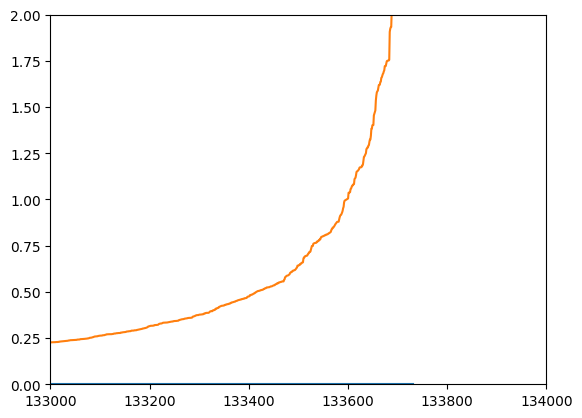

In [ ]:
distances = np.sort(distances, axis=0)
#distances = distances[:,1]
plt.plot(distances)


plt.xlim(133000, 134000)  # Set the x-axis limits from 50 to 100
plt.ylim(0, 2)    # Set the y-axis limits from 0 to 10

plt.show


In [ ]:
dbscan = DBSCAN(eps=0.7, min_samples=6)
dbscan.fit(X)

DBSCAN(eps=0.7, min_samples=6)

In [ ]:
#Noisy samples are given the label -1.
dbscan.labels_

array([  0,   0,   0, ..., 800, 800, 800])

In [ ]:
cl=pd.DataFrame(dbscan.labels_,columns=['cluster'])

In [ ]:
cl

,cluster
0,0
1,0
2,0
3,0
4,0
...,...
133726,800
133727,800
133728,800
133729,800


In [ ]:
cl.value_counts()

cluster
240        3520
650        1634
737        1542
382        1527
690        1436
           ... 
76            6
401           6
842           6
725           5
729           4
Length: 844, dtype: int64

In [ ]:
pd.concat([df_train,cl],axis=1)

,Quant,Val,Prod_p1000,Prod_p1001,Prod_p1002,Prod_p1007,Prod_p1014,Prod_p1019,Prod_p1027,Prod_p1040,...,Prod_p985,Prod_p989,Prod_p99,Prod_p991,Prod_p993,Prod_p994,Prod_p996,Prod_p997,Prod_p998,cluster
0,1032.0,4115.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,718.0,4780.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,585.0,3810.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,904.0,7310.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6989.0,35850.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133726,381.0,4695.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,800
133727,100.0,1080.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,800
133728,0.0,1020.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,800
133729,103.0,1320.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,800


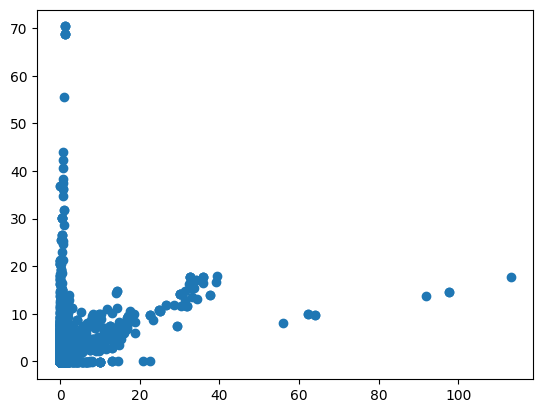

In [ ]:
plt.scatter(X[:,0], X[:,1])

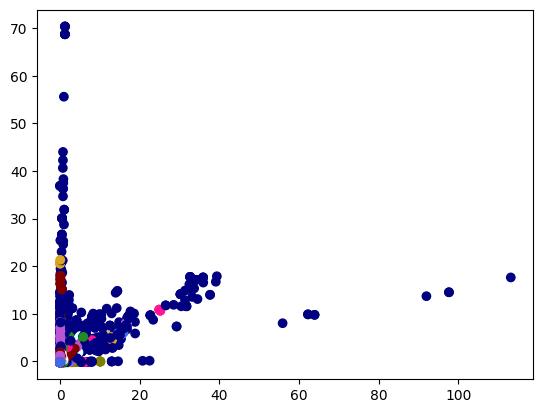

In [ ]:
colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'navy']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
plt.scatter(X[:,0], X[:,1], c=vectorizer(dbscan.labels_))

## Evaluation on Test Data

In [ ]:
stscaler = StandardScaler().fit(X_test)
X = stscaler.transform(X_test)

In [ ]:
X

array([[-0.01233685,  1.40990729, -0.07998209, ..., -0.02875804,
        -0.01594752, -0.03989545],
       [-0.0235217 , -0.34851517, -0.07998209, ..., -0.02875804,
        -0.01594752, -0.03989545],
       [-0.01229615,  1.22766286, -0.07998209, ..., -0.02875804,
        -0.01594752, -0.03989545],
       ...,
       [-0.02331224, -0.1774582 , -0.07998209, ..., -0.02875804,
        -0.01594752, -0.03989545],
       [-0.02343589, -0.25534335, -0.07998209, ..., -0.02875804,
        -0.01594752, -0.03989545],
       [-0.02299674, -0.01946748, -0.07998209, ..., -0.02875804,
        -0.01594752, -0.03989545]])

In [ ]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

<function matplotlib.pyplot.show(close=None, block=None)>

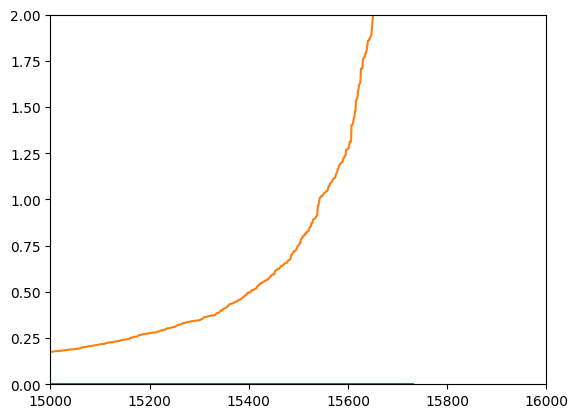

In [ ]:
distances = np.sort(distances, axis=0)
#distances = distances[:,1]
plt.plot(distances)

plt.xlim(15000, 16000)  # Set the x-axis limits from 50 to 100
plt.ylim(0, 2)    # Set the y-axis limits from 0 to 10

plt.show


In [ ]:
dbscan = DBSCAN(eps=.7, min_samples=6)
dbscan.fit(X)

DBSCAN(eps=0.7, min_samples=6)

In [ ]:
#Noisy samples are given the label -1.
dbscan.labels_

array([  0,   0,   0, ..., 392, 392, 392])

In [ ]:
cl=pd.DataFrame(dbscan.labels_,columns=['cluster'])

In [ ]:
cl

,cluster
0,0
1,0
2,0
3,0
4,1
...,...
15727,392
15728,392
15729,392
15730,392


In [ ]:
cl.value_counts()

cluster
-1         1284
 105        399
 363        190
 207        174
 148        174
           ... 
 522          6
 129          6
 20           6
 525          6
 424          6
Length: 555, dtype: int64

In [ ]:
results = pd.concat([test_data,cl],axis=1)

In [ ]:
results.head(15732)

,ID,Prod,Quant,Val,Insp,cluster
0,v42,p11,51097.0,310780.0,ok,0
1,v45,p11,260.0,1925.0,ok,0
2,v42,p11,51282.0,278770.0,ok,0
3,v50,p11,46903.0,281485.0,ok,0
4,v46,p12,475.0,2600.0,ok,1
...,...,...,...,...,...,...
15727,v3854,p4096,1567.0,21180.0,ok,392
15728,v3179,p4096,907.0,17350.0,ok,392
15729,v4561,p4096,1212.0,31970.0,ok,392
15730,v3179,p4096,650.0,18290.0,ok,392


In [ ]:
results['Actual'] = results['Insp'].apply(lambda x: 1 if x == 'fraud' else 0)
results['Predicted'] = results['cluster'].apply(lambda x: 1 if x == -1 else 0)
results

,ID,Prod,Quant,Val,Insp,cluster,Actual,Predicted
0,v42,p11,51097.0,310780.0,ok,0,0,0
1,v45,p11,260.0,1925.0,ok,0,0,0
2,v42,p11,51282.0,278770.0,ok,0,0,0
3,v50,p11,46903.0,281485.0,ok,0,0,0
4,v46,p12,475.0,2600.0,ok,1,0,0
...,...,...,...,...,...,...,...,...
15727,v3854,p4096,1567.0,21180.0,ok,392,0,0
15728,v3179,p4096,907.0,17350.0,ok,392,0,0
15729,v4561,p4096,1212.0,31970.0,ok,392,0,0
15730,v3179,p4096,650.0,18290.0,ok,392,0,0


In [ ]:
# Compare the predicted labels with the true labels and evaluate the model's performance
accuracy = accuracy_score(results['Actual'],results['Predicted'])
precision = precision_score(results['Actual'],results['Predicted'])
recall = recall_score(results['Actual'],results['Predicted'])
f1 = f1_score(results['Actual'],results['Predicted'])

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Accuracy: 0.8916857360793288
Precision: 0.3309968847352025
Recall: 0.3346456692913386
F1-Score: 0.3328112764291308


#Confusion Matrix

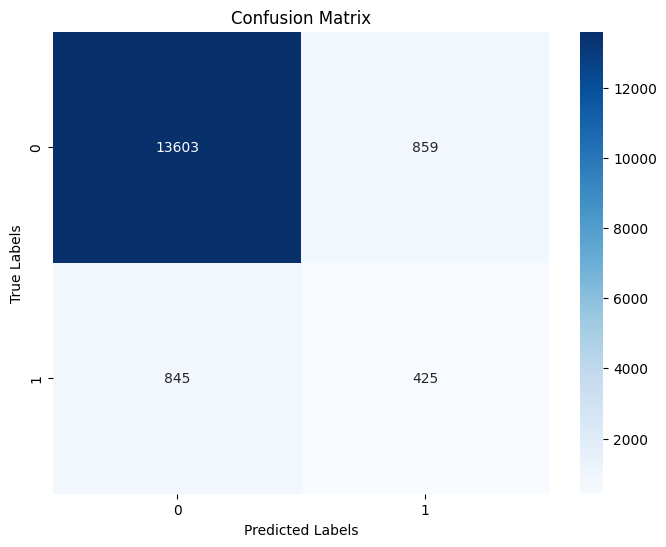

In [ ]:
# Create the confusion matrix
cm1 = confusion_matrix(results['Actual'],results['Predicted'])

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### Precision-Recall Curve

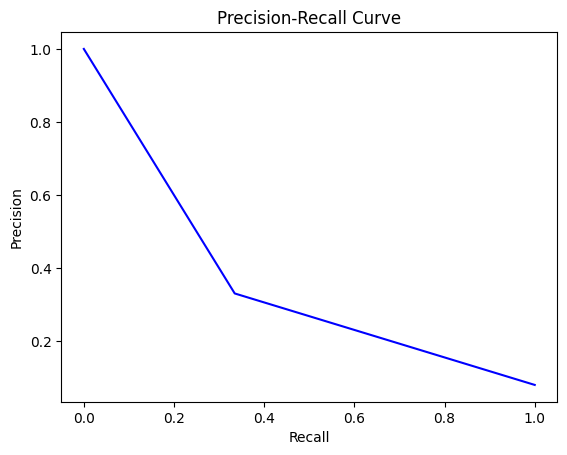

In [ ]:
# Compute precision and recall
precision2, recall2, thresholds2 = precision_recall_curve(results['Actual'],results['Predicted'])


# Plot the precision-recall curve
plt.plot(recall2, precision2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

### ROC Curve

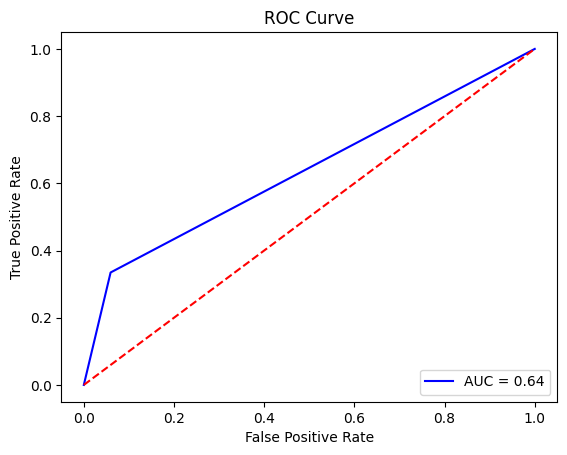

In [ ]:
# Compute false positive rate and true positive rate
fpr2, tpr2, thresholds2 = roc_curve(results['Actual'],results['Predicted'])
roc_auc2 = roc_auc_score(results['Actual'],results['Predicted'])

# Plot the ROC curve
plt.plot(fpr2, tpr2, color='b', label=f'AUC = {roc_auc2:.2f}')
plt.plot([0, 1], [0, 1], color='r', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()